In [2]:
# -----------------------------
# 0) Imports
# -----------------------------
import re
import string
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)

import matplotlib.pyplot as plt
#%matplotlib inline

import joblib

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_colwidth", 200)


In [ ]:
# 1) Load Data
CSV_PATH = "..\\datasets\\processed\\final_dataset_sentiment_analysis.csv"

df = pd.read_csv(CSV_PATH)

C:\Users\yogan\AppData\Local\Temp\ipykernel_42600\2793368141.py:9: DtypeWarning: Columns (0: dateAdded, 1: dateUpdated, 2: imageURLs, 3: manufacturerNumber, 4: primaryCategories, 5: sourceURLs) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CSV_PATH)


In [ ]:
df.columns

Index(['asins', 'brand', 'categories', 'dateAdded', 'dateUpdated', 'id',
       'imageURLs', 'keys', 'manufacturer', 'manufacturerNumber', 'name',
       'primaryCategories', 'reviews.date', 'reviews.dateAdded',
       'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend',
       'reviews.id', 'reviews.numHelpful', 'reviews.rating',
       'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username',
       'sourceURLs'],
      dtype='str')

In [ ]:
# 2) checking rating distribution
# If ratings are floats (like 4.0, 5.0), convert first:
#Count how many 1-star, 2-star, 3-star, 4-star, 5-star reviews

df["reviews.rating"] = pd.to_numeric(df["reviews.rating"], errors="coerce")
df["reviews.rating"] = df["reviews.rating"].astype("Int64")

df["reviews.rating"].value_counts().sort_index()

reviews.rating
1     1333
2      979
3     2566
4    13403
5    41316
Name: count, dtype: Int64

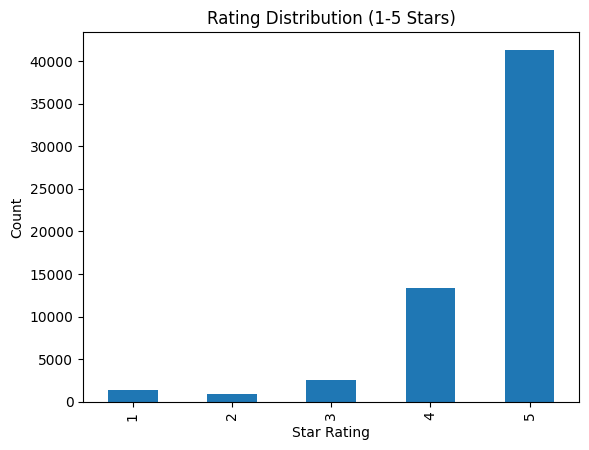

In [6]:
#Plot the distribution of ratings (1-5 stars)
df["reviews.rating"].value_counts().sort_index().plot(kind="bar")
plt.title("Rating Distribution (1-5 Stars)")
plt.xlabel("Star Rating")
plt.ylabel("Count")
plt.show()


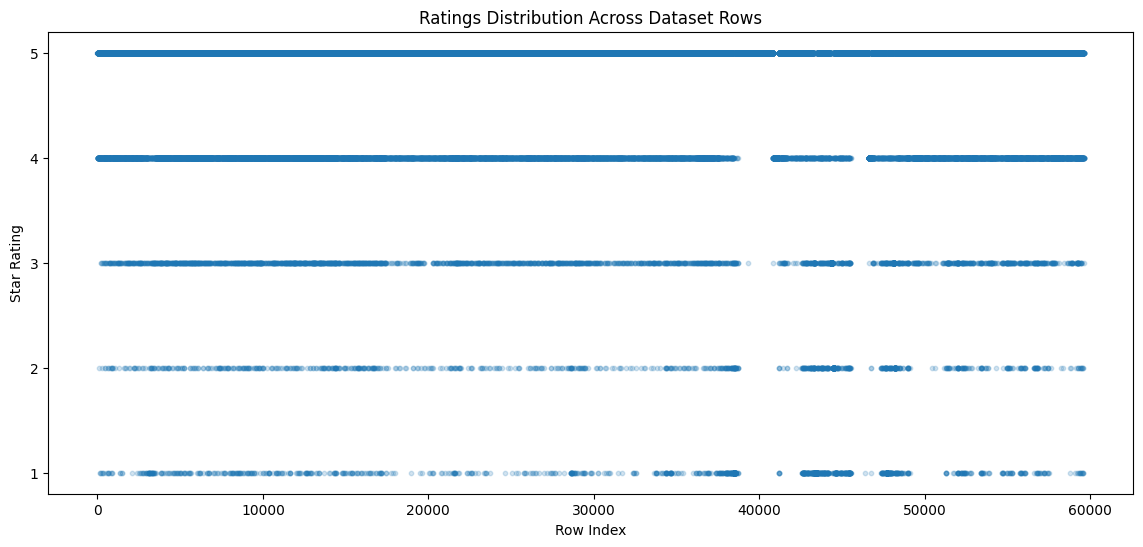

In [7]:
#Ratings distribution across dataset rows (scatter plot)
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.scatter(df.index, df["reviews.rating"], alpha=0.2, s=10)

plt.title("Ratings Distribution Across Dataset Rows")
plt.xlabel("Row Index")
plt.ylabel("Star Rating")
plt.yticks([1,2,3,4,5])
plt.show()


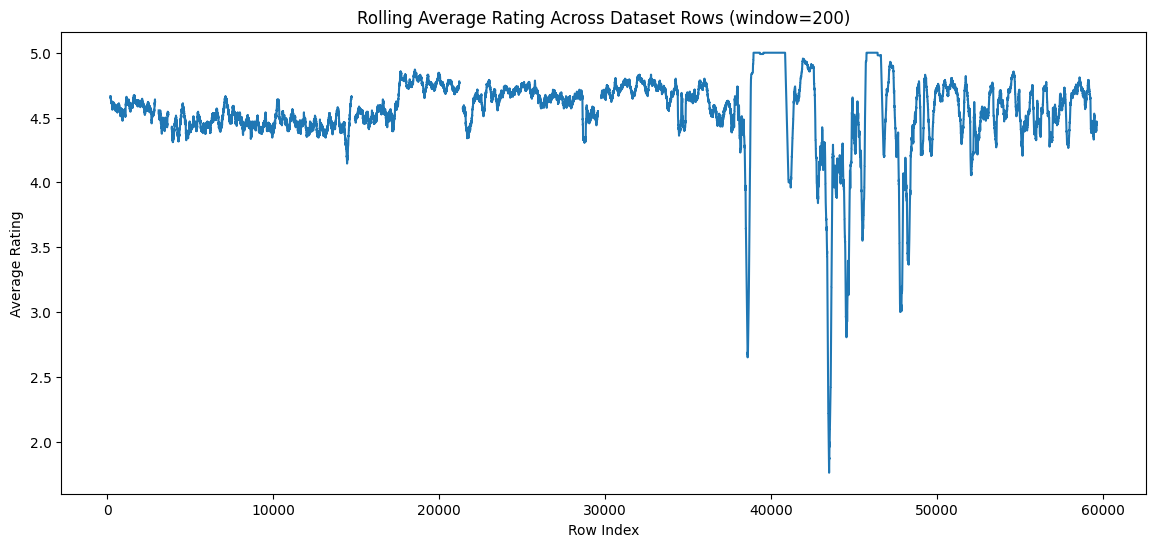

In [8]:
#Rolling mean trend
plt.figure(figsize=(14,6))

rolling_mean = df["reviews.rating"].rolling(window=200).mean()

plt.plot(df.index, rolling_mean)

plt.title("Rolling Average Rating Across Dataset Rows (window=200)")
plt.xlabel("Row Index")
plt.ylabel("Average Rating")
plt.show()


In [ ]:

# -----------------------------
# Typical columns in this dataset:
# - reviews.text
# - reviews.title
# - reviews.rating

# If your columns differ, adapt here:
TEXT_COL = "reviews.text"
TITLE_COL = "reviews.title" if "reviews.title" in df.columns else None
RATING_COL = "reviews.rating"

# Basic sanity checks:
assert TEXT_COL in df.columns, f"Missing {TEXT_COL}. Check your column names."
assert RATING_COL in df.columns, f"Missing {RATING_COL}. Check your column names."

# Optionally combine title + text (often boosts accuracy slightly)
def combine_title_text(row):
    t = str(row[TEXT_COL]) if pd.notna(row[TEXT_COL]) else ""
    if TITLE_COL and pd.notna(row.get(TITLE_COL, np.nan)):
        title = str(row[TITLE_COL]).strip()
        if title and title.lower() != "nan":
            return (title + ". " + t).strip()
    return t.strip()

df["text_raw"] = df.apply(combine_title_text, axis=1)
# Keep only needed columns for sentiment task
keep_cols = ["text_raw", RATING_COL]
df_sent = df[keep_cols].copy()

In [10]:
# -----------------------------
# 3) Basic Cleaning + Quality Filters
# -----------------------------
# Drop missing/empty text
df_sent["text_raw"] = df_sent["text_raw"].astype(str)
df_sent["text_raw"] = df_sent["text_raw"].replace("nan", "").str.strip()
df_sent = df_sent[df_sent["text_raw"].str.len() > 0].copy()

# Ensure rating numeric
df_sent[RATING_COL] = pd.to_numeric(df_sent[RATING_COL], errors="coerce")
df_sent = df_sent.dropna(subset=[RATING_COL]).copy()

# Remove duplicates (VERY important for realistic evaluation)
df_sent = df_sent.drop_duplicates(subset=["text_raw", RATING_COL]).copy()

print("After cleaning/filters:", df_sent.shape)
display(df_sent.head())

After cleaning/filters: (46978, 2)


,text_raw,reviews.rating
0,Kindle. This product so far has not disappointed. My children love to use it and I like the ability to monitor control what content they see with ease.,5
1,very fast. great for beginner or experienced person. Bought as a gift and she loves it,5
2,"Beginner tablet for our 9 year old son.. Inexpensive tablet for him to use and learn on, step up from the NABI. He was thrilled with it, learn how to Skype on it already...",5
3,Good!!!. I've had my Fire HD 8 two weeks now and I love it. This tablet is a great value.We are Prime Members and that is where this tablet SHINES. I love being able to easily access all of the Pr...,4
4,"Fantastic Tablet for kids. I bought this for my grand daughter when she comes over to visit. I set it up with her as the user, entered her age and name and now Amazon makes sure that she only acce...",5


In [11]:
# -----------------------------
# 4) Create Sentiment Labels from Ratings
# -----------------------------
def map_rating_to_sentiment(r):
    # Recommended mapping:
    # 1-2 => negative, 3 => neutral, 4-5 => positive
    if r <= 2:
        return "negative"
    elif r == 3:
        return "neutral"
    else:
        return "positive"

df_sent["sentiment"] = df_sent[RATING_COL].apply(map_rating_to_sentiment)

print(df_sent["sentiment"].value_counts(dropna=False))


sentiment
positive    43088
neutral      2051
negative     1839
Name: count, dtype: int64


In [12]:
# -----------------------------
# 5) Text Preprocessing Function
# -----------------------------
# For classical ML + TF-IDF, keep it LIGHT:
# - lowercase
# - remove URLs, HTML tags
# - normalize whitespace
# Avoid aggressive stopword removal (often hurts sentiment).
URL_RE = re.compile(r"https?://\S+|www\.\S+")
HTML_RE = re.compile(r"<.*?>")
MULTISPACE_RE = re.compile(r"\s+")

def clean_text(s: str) -> str:
    s = s.lower()
    s = URL_RE.sub(" ", s)
    s = HTML_RE.sub(" ", s)
    s = s.replace("\n", " ").replace("\r", " ")
    s = MULTISPACE_RE.sub(" ", s).strip()
    return s

df_sent["text"] = df_sent["text_raw"].apply(clean_text)

# Optional: remove extremely short reviews (often noise)
# Keep if you want, but it can improve quality.
df_sent = df_sent[df_sent["text"].str.len() >= 3].copy()

print("Final dataset size:", df_sent.shape)
display(df_sent.sample(5, random_state=42))


Final dataset size: (46978, 4)


,text_raw,reviews.rating,sentiment,text
40397,Five Stars. These are great. Best price I could find on Amazon. I'll be using these from now.,5,positive,five stars. these are great. best price i could find on amazon. i'll be using these from now.
43214,"Nice performance from these batteries!. Speedy delivery, convenient packaging - and the batteries seemed to last longer than usual in my application (wireless mikes) - still had 3 bars at the end ...",5,positive,"nice performance from these batteries!. speedy delivery, convenient packaging - and the batteries seemed to last longer than usual in my application (wireless mikes) - still had 3 bars at the end ..."
5065,"Good tablet for basic apps. Great tablet. Love reading my books, playing puzzles, and going on basic social apps.",5,positive,"good tablet for basic apps. great tablet. love reading my books, playing puzzles, and going on basic social apps."
53593,Great Product. This generation of kindle fire is excellent. The addition of alexa was key.,5,positive,great product. this generation of kindle fire is excellent. the addition of alexa was key.
37770,Always a good buy!. Always a good buy!,5,positive,always a good buy!. always a good buy!


In [13]:
# -----------------------------
# 6) Train/Validation/Test Split (Stratified)
# -----------------------------
X = df_sent["text"].values
y = df_sent["sentiment"].values

# 80/20 train+temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# Split temp into validation/test => 10/10
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))

Train: 37582 Val: 4698 Test: 4698


In [14]:
# -----------------------------
# 7) Evaluation Helpers
# -----------------------------
LABELS = ["negative", "neutral", "positive"]

def plot_confusion(cm, labels, title):
    fig = plt.figure(figsize=(6, 5))
    plt.imshow(cm)
    plt.title(title)
    plt.xticks(range(len(labels)), labels, rotation=30)
    plt.yticks(range(len(labels)), labels)

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

In [15]:
def evaluate_model(name, model, X_tr, y_tr, X_va, y_va):
    model.fit(X_tr, y_tr)
    pred = model.predict(X_va)

    acc = accuracy_score(y_va, pred)
    f1_macro = f1_score(y_va, pred, average="macro")
    f1_weighted = f1_score(y_va, pred, average="weighted")
    prec_macro = precision_score(y_va, pred, average="macro", zero_division=0)
    rec_macro = recall_score(y_va, pred, average="macro", zero_division=0)

    print(f"\n===== {name} (Validation) =====")
    print("Accuracy:", round(acc, 4))
    print("F1 macro:", round(f1_macro, 4))
    print("F1 weighted:", round(f1_weighted, 4))
    print("\nClassification report:\n", classification_report(y_va, pred, digits=4))

    cm = confusion_matrix(y_va, pred, labels=LABELS)
    plot_confusion(cm, LABELS, f"{name} - Confusion Matrix (Val)")

    return {
        "model": name,
        "acc_val": acc,
        "f1_macro_val": f1_macro,
        "f1_weighted_val": f1_weighted,
        "precision_macro_val": prec_macro,
        "recall_macro_val": rec_macro
    }


In [16]:
# 8) Build 3 Pipelines (TF-IDF + Classifier)
# -----------------------------
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    # For very large data you can cap features:
    # max_features=80000,
    sublinear_tf=True
)

In [17]:

# Model 1: LinearSVC (strong baseline)
pipe_svc = Pipeline([
    ("tfidf", tfidf),
    ("clf", LinearSVC(class_weight="balanced", random_state=42))
])


===== TFIDF + LinearSVC (Validation) =====
Accuracy: 0.9385
F1 macro: 0.663
F1 weighted: 0.9336

Classification report:
               precision    recall  f1-score   support

    negative     0.7000    0.6467    0.6723       184
     neutral     0.4275    0.2878    0.3440       205
    positive     0.9638    0.9819    0.9728      4309

    accuracy                         0.9385      4698
   macro avg     0.6971    0.6388    0.6630      4698
weighted avg     0.9301    0.9385    0.9336      4698



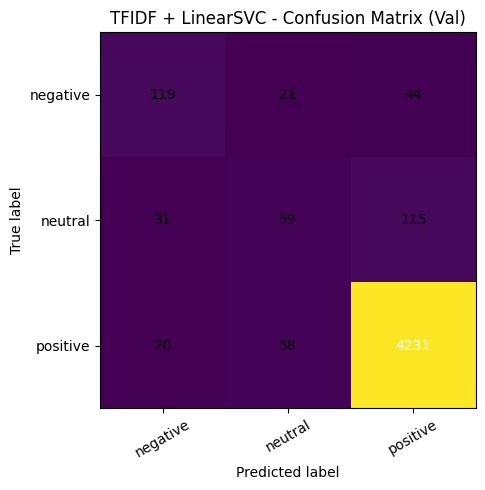

,model,acc_val,f1_macro_val,f1_weighted_val,precision_macro_val,recall_macro_val
0,TFIDF + LinearSVC,0.938484,0.663032,0.933554,0.697106,0.638814


In [18]:
# 9) Train + Evaluate on Validation
# -----------------------------
results = []
results.append(evaluate_model("TFIDF + LinearSVC", pipe_svc, X_train, y_train, X_val, y_val))

results_df = pd.DataFrame(results).sort_values(by="f1_macro_val", ascending=False)
display(results_df)

Best model by macro F1 on validation: TFIDF + LinearSVC

===== FINAL TEST RESULTS =====
Accuracy: 0.947
F1 macro: 0.6973
F1 weighted: 0.9422

Classification report:
               precision    recall  f1-score   support

    negative     0.7556    0.7391    0.7473       184
     neutral     0.4662    0.3024    0.3669       205
    positive     0.9694    0.9865    0.9779      4309

    accuracy                         0.9470      4698
   macro avg     0.7304    0.6760    0.6973      4698
weighted avg     0.9391    0.9470    0.9422      4698



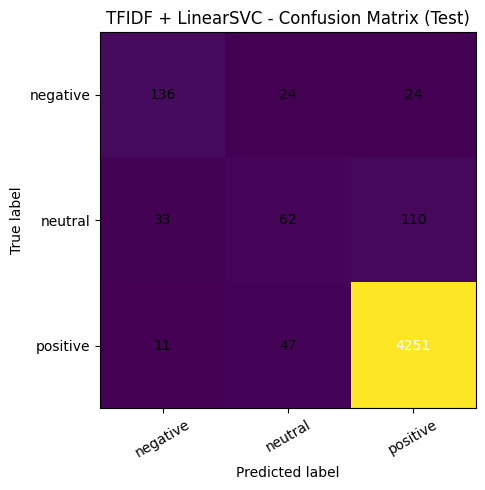

In [19]:

#  Model and Evaluate on Test

best_name = results_df.iloc[0]["model"]
print("Best model by macro F1 on validation:", best_name)

name_to_model = {
    "TFIDF + LinearSVC": pipe_svc,
   
    
}
best_model = name_to_model[best_name]

# Retrain on train + val combined
X_trainval = np.concatenate([X_train, X_val])
y_trainval = np.concatenate([y_train, y_val])

best_model.fit(X_trainval, y_trainval)
test_pred = best_model.predict(X_test)

print("\n===== FINAL TEST RESULTS =====")
print("Accuracy:", round(accuracy_score(y_test, test_pred), 4))
print("F1 macro:", round(f1_score(y_test, test_pred, average="macro"), 4))
print("F1 weighted:", round(f1_score(y_test, test_pred, average="weighted"), 4))
print("\nClassification report:\n", classification_report(y_test, test_pred, digits=4))

cm_test = confusion_matrix(y_test, test_pred, labels=LABELS)
plot_confusion(cm_test, LABELS, f"{best_name} - Confusion Matrix (Test)")

In [20]:
df.columns

Index(['asins', 'brand', 'categories', 'dateAdded', 'dateUpdated', 'id',
       'imageURLs', 'keys', 'manufacturer', 'manufacturerNumber', 'name',
       'primaryCategories', 'reviews.date', 'reviews.dateAdded',
       'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend',
       'reviews.id', 'reviews.numHelpful', 'reviews.rating',
       'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username',
       'sourceURLs', 'text_raw'],
      dtype='str')

In [22]:
df.shape

(59630, 28)

In [23]:
df_sent.shape

(46978, 4)

In [ ]:
# ADDITIONAL: Predict on full dataset df and add new column

# 1) Build the SAME text field used during training
# (title + text is consistent with your notebook style)
df["text_raw_all"] = (
    df["reviews.title"].fillna("").astype(str).str.strip()
    + ". "
    + df["reviews.text"].fillna("").astype(str).str.strip()
)

# 2) Apply the SAME cleaning function you used in training
df["text_clean_all"] = df["text_raw_all"].apply(clean_text)

# 3) Predict (avoid empty/too-short strings if you filtered them in training)
mask_valid_all = df["text_clean_all"].fillna("").str.len() >= 3

# Create the output column
df["predicted_sentiment_all"] = None

# Predict only for valid rows
df.loc[mask_valid_all, "predicted_sentiment_all"] = best_model.predict(
    df.loc[mask_valid_all, "text_clean_all"]
)

# Optional: quick sanity check
df[["reviews.title", "reviews.text", "predicted_sentiment_all"]].head(10)

,reviews.title,reviews.text,predicted_sentiment_all
0,Kindle,This product so far has not disappointed. My children love to use it and I like the ability to monitor control what content they see with ease.,positive
1,very fast,great for beginner or experienced person. Bought as a gift and she loves it,positive
2,Beginner tablet for our 9 year old son.,"Inexpensive tablet for him to use and learn on, step up from the NABI. He was thrilled with it, learn how to Skype on it already...",positive
3,Good!!!,I've had my Fire HD 8 two weeks now and I love it. This tablet is a great value.We are Prime Members and that is where this tablet SHINES. I love being able to easily access all of the Prime conte...,positive
4,Fantastic Tablet for kids,"I bought this for my grand daughter when she comes over to visit. I set it up with her as the user, entered her age and name and now Amazon makes sure that she only accesses sites and content that...",positive
5,Just what we expected,This amazon fire 8 inch tablet is the perfect size. I purchased it for my husband so that he has a bigger screen than just his phone. He had gotten me one a few years ago so I knew it would be a g...,positive
6,great e-reader tablet,"Great for e-reading on the go, nice and light weight, and for the price point given, definitely worth the purchase.",positive
7,Great for gifts,"I gave this as a Christmas gift to my inlaws, husband and uncle. They loved it and how easy they are to use with fantastic features!",positive
8,Great for reading,Great as a device to read books. I like that it links with my borrowed library e-books. Switched from another popular tablet brand and I am happy with the choice I made. It took some time to get b...,positive
9,Great and lightweight reader,I love ordering books and reading them with the reader.,positive


In [27]:
df.columns

Index(['asins', 'brand', 'categories', 'dateAdded', 'dateUpdated', 'id',
       'imageURLs', 'keys', 'manufacturer', 'manufacturerNumber', 'name',
       'primaryCategories', 'reviews.date', 'reviews.dateAdded',
       'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend',
       'reviews.id', 'reviews.numHelpful', 'reviews.rating',
       'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username',
       'sourceURLs', 'text_raw', 'text_raw_all', 'text_clean_all',
       'predicted_sentiment_all'],
      dtype='str')

In [28]:
export_cols = [
    "reviews.id",
    "asins",
    "name",
    "reviews.text",
    "reviews.rating",
    "predicted_sentiment_all"
]

df_export = df[export_cols].copy()

df_export.to_csv("..//datasets//processed//sentiment_enriched_reviews.csv", index=False)
